# Z500_WT-annomalies.ipynb

#!/usr/bin/env python

    File name: Z500_WT-annomalies.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 26.01.2021
    Date last modified: 26.01.2021

    ############################################################## 
    Purpos:
    Calculates Z500 annomalies for each WT
    
    This requires to first run:
    ~/projects/Arizona_WTing/programs/WTing/Centroids-and-Scatterplot.py

    1) read in the WT arrays for focus basis

    2) read in daily mean ERA5 500 hPa ZG values

    3) plot ZG annomalies on map


In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from scipy import signal
from numpy.linalg import lstsq
import random

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

### Setup

In [2]:
sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/Z500_WT-annomalies/'
sDataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/'
HUC2 = ['1501','1502', '1503', '1504','1505', '1506', '1507', '1810','HUC6-00','HUC6-01','HUC6-02','HUC6-03','HUC6-04','HUC6-05']
DW_Regions=[['1501', '1503', '1507', '1810'], ['1502', '1504','1505', '1506'],['HUC6-00','HUC6-01','HUC6-02','HUC6-05'],['HUC6-03','HUC6-04']]
REGIONS = ['AZ_West','AZ_East','NM_North','NM_South']
sMonths='6-7-8-9-10'
Season = 'JJASO'
YYYY_stamp='1982-2018'
iNrOfExtremes = 13514
iMonths=[6,7,8,9,10]

VarComp = [['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850']]

### Load the Eucledian Distances and the Daily Precipitation for each Region

In [3]:
for re in range(len(HUC2)):
    sRegion=HUC2[re]
    ss='-'
    VarsJoint=ss.join(VarComp[re])
    sClusterSave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season
    with open(sClusterSave, 'rb') as handle:
        DATA = pickle.load(handle)
    grEucledianDist = DATA['grEucledianDist']['Full']
    rgdTime = DATA['rgdTime']
    Peval = DATA['Peval']
    ClusterArray = DATA['grClustersFin']['Full'][1]
    LonWT = DATA['LonWT']
    LatWT = DATA['LatWT']
    if re == 0:
        PR_All = np.zeros((len(rgdTime),len(HUC2))); PR_All[:]=np.nan
        PR_All_GC = np.zeros((len(rgdTime), 10000, len(HUC2))); PR_All[:]=np.nan
        Cluster_All = np.copy(PR_All)
    
    sPRsave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+sMonths+'.npz'
    npzfile = np.load(sPRsave)
    rgrPRrecords=npzfile['rgrPRrecords']
    
    PR_All[:,re] = rgrPRrecords
    PR_All_GC[:,:Peval.shape[1],re]=Peval
    
    # sort WTs from dry to wet
    TEST = np.nanmean(DATA['Peval'], axis=1)
    WT_PR = [np.nanmean(TEST[DATA['grClustersFin']['Full'][1] == wt]) for wt in range(np.max(DATA['grClustersFin']['Full'][1])+1)]
    iWT_sort = np.argsort(WT_PR)
    ClusterTMP = np.copy(ClusterArray); ClusterTMP[:] = np.nan
    for wt in range(len(iWT_sort)):
        ClusterTMP[ClusterArray == wt] = np.where(iWT_sort == wt)[0][0]
    Cluster_All[:,re] = ClusterTMP


### Merge the basins into main clusters

In [4]:
WTsFIN = np.zeros((PR_All.shape[0],len(DW_Regions))); WTsFIN[:] = np.nan
PR_FIN = np.zeros((PR_All.shape[0],len(DW_Regions))); PR_FIN[:] = np.nan
for re in range(len(DW_Regions)):
    iClusterReg = HUC2.index(DW_Regions[re][0])
    WTsFIN[:,re] = Cluster_All[:,iClusterReg]
    matching = [HUC2.index(DW_Regions[re][ii]) for ii in range(len(DW_Regions[re]))]
    PR_FIN[:,re] = np.nanmean(PR_All_GC[:,:,matching],axis=(1,2))

### Read in daily ERA-Interim ZG500 values

In [5]:
from datetime import datetime
rgiYears=np.unique(rgdTime.year)

rgsWTvars=['ZG500']
ERA_Var = ['z']
rgsWTfolders = ['/glade/campaign/mmm/c3we/prein/ERA-Interim/Z500/Z500_daymean_']

ncid=Dataset('/glade/scratch/prein/ERA-Interim/PSL/fin_PSL-sfc_ERA-Interim_12-0_2014.nc', mode='r') # open the netcdf file
rgrLatWT1D=np.squeeze(ncid.variables['lat'][:])
rgrLonWT1D=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrLonWT=np.asarray(([rgrLonWT1D,]*rgrLatWT1D.shape[0]))
# rgrLonWT[rgrLonWT > 180]=rgrLonWT[rgrLonWT > 180]-360
rgrLatWT=np.asarray(([rgrLatWT1D,]*rgrLonWT1D.shape[0])).transpose()

DailyVars=np.zeros((len(rgdTime),rgrLonWT.shape[0],rgrLonWT.shape[1])); DailyVars[:]=np.nan
for yy in range(len(rgiYears)):
    print('        Read ERA-I year: '+str(rgiYears[yy]))
    DaysYY = pd.date_range(datetime(rgiYears[yy], 1, 1,0), end=datetime(rgiYears[yy], 12, 31,23), freq='d')
    DD=((rgdTime.year == rgiYears[yy]) & np.isin(rgdTime.month, iMonths))
    DDactYYYY=np.isin(DaysYY.month, iMonths)
    # DDactYYYY=((DaysYY.month >= iStartMon) & (DaysYY.month <= iStopMon))
    for va in range(len(rgsWTvars)):
        ncid=Dataset(rgsWTfolders[va]+str(rgiYears[yy])+'.nc', mode='r')
        try:
            DailyVars[DD,:,:]=np.squeeze(np.squeeze(ncid.variables[ERA_Var[va]])[:,:,:])[DDactYYYY,:]
        except:
            stop()
        ncid.close()

        Read ERA-I year: 1982
        Read ERA-I year: 1983
        Read ERA-I year: 1984
        Read ERA-I year: 1985
        Read ERA-I year: 1986
        Read ERA-I year: 1987
        Read ERA-I year: 1988
        Read ERA-I year: 1989
        Read ERA-I year: 1990
        Read ERA-I year: 1991
        Read ERA-I year: 1992
        Read ERA-I year: 1993
        Read ERA-I year: 1994
        Read ERA-I year: 1995
        Read ERA-I year: 1996
        Read ERA-I year: 1997
        Read ERA-I year: 1998
        Read ERA-I year: 1999
        Read ERA-I year: 2000
        Read ERA-I year: 2001
        Read ERA-I year: 2002
        Read ERA-I year: 2003
        Read ERA-I year: 2004
        Read ERA-I year: 2005
        Read ERA-I year: 2006
        Read ERA-I year: 2007
        Read ERA-I year: 2008
        Read ERA-I year: 2009
        Read ERA-I year: 2010
        Read ERA-I year: 2011
        Read ERA-I year: 2012
        Read ERA-I year: 2013
        Read ERA-I year: 2014
        Re

In [24]:
from tqdm import tqdm
ERA_climmean = np.mean(DailyVars, axis=0)
ERA_ClimSTD = np.std(DailyVars/9.81, axis=0)
Anommalies_WTs = np.zeros((ERA_climmean.shape[0],ERA_climmean.shape[1],3,WTsFIN.shape[1])); Anommalies_WTs[:] = np.nan
Significance = np.copy(Anommalies_WTs)
for re in range(WTsFIN.shape[1]):
    for wt in range(3):
        iDD = WTsFIN[:,re] == wt
        WT_mean = np.mean(DailyVars[iDD,:,:], axis=0)
        Anommalies_WTs[:,:,wt,re] = WT_mean - ERA_climmean
#         for la in tqdm(range(ERA_climmean.shape[0])[::10]):
#             for lo in range(ERA_climmean.shape[1])[::10]:
#                 statisitc , Significance[la,lo,wt,re] = scipy.stats.mannwhitneyu(DailyVars[iDD == False], DailyVars[iDD == True])
        
Anommalies_WTs = Anommalies_WTs/9.81

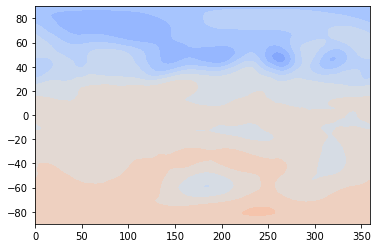

In [57]:
plt.contourf(rgrLonWT,rgrLatWT,Anommalies_WTs[:,:,0,2], levels=np.linspace(-100,100,21), extend='both',cmap='coolwarm')

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color', 'edgecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


        Plot map to: ZG500_WT_annomalies.pdf


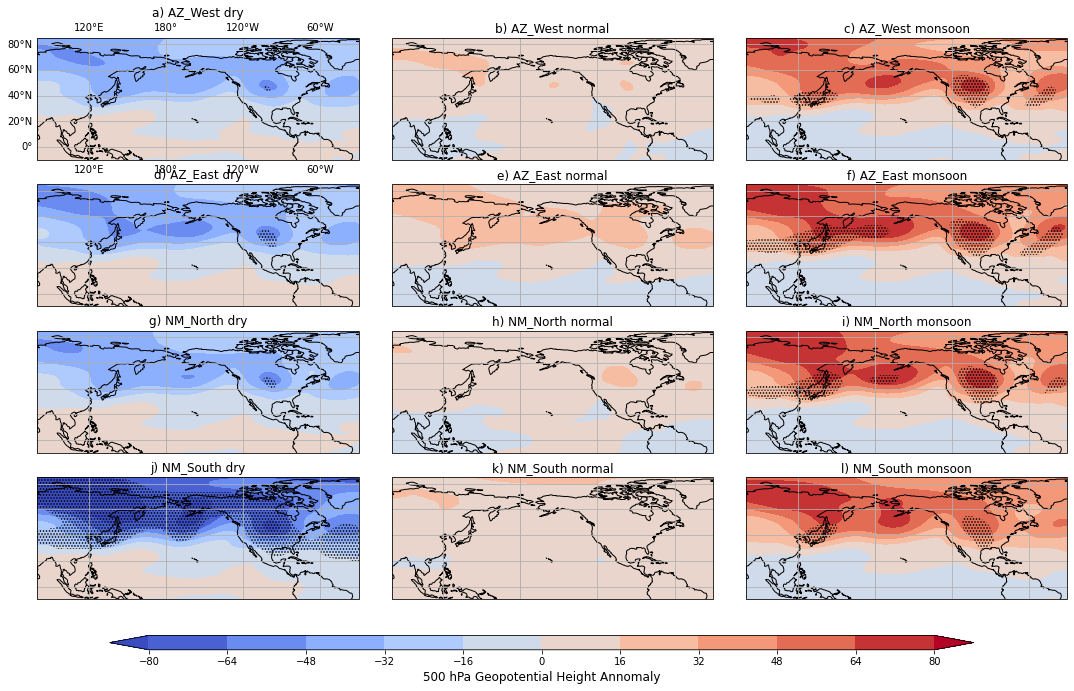

In [56]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

ObjectsSort = ['MCSs','MCS_PR'] 
WTnames = ['dry','normal','monsoon']

fig = plt.figure(figsize=(15,10))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(4,3)
gs1.update(left=0.03, right=0.99,
   bottom=0.15, top=0.93,
   wspace=0.08, hspace=0.2)

for re in range(WTsFIN.shape[1]):
    for wt in range(3):
        
        proj = ccrs.PlateCarree(180) #ccrs.Robinson() 
        ax = plt.subplot(gs1[re,wt], projection=proj)
        pos1 = ax.get_position()
        cs = plt.contourf(rgrLonWT,rgrLatWT,Anommalies_WTs[:,:,wt,re], transform=ccrs.PlateCarree(), levels=np.linspace(-80,80,11), extend='both', cmap='coolwarm')#, cmap='hot_r')
#         plt.title(rgsLableABC[se+st*4]+') '+season+' '+Label)
        plt.contourf(rgrLonWT,rgrLatWT, np.abs(Anommalies_WTs[:,:,wt,re]) >= ERA_ClimSTD/2 , levels=[0,0.9,1.1] ,
                     transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","...."],alpha=0.)

        
        ax.coastlines()
        ax.set_extent((80, 180+150, -10, 85), ccrs.PlateCarree())
        if (re == 0) & (wt == 0):
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.right_labels = False
        else:
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.top_labels = gl.right_labels = gl.left_labels = gl.bottom_labels = False
            
        plt.title(rgsLableABC[wt+re*3]+') '+REGIONS[re]+' '+WTnames[wt])
            
CbarAx = axes([0.1, 0.08, 0.8, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.linspace(-80,80,11))
cb.set_label('500 hPa Geopotential Height Annomaly', fontsize=12)

sPlotFile=''
sPlotName= 'ZG500_WT_annomalies.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)